# Direct Marketing Prediction

In this notebook, we are going to explore the direct marketing dataset. First, we start off with Exploratory Data Analysis, followed by feature engineering steps, walk through imputation, apply Machine Learning models, and interpret the results. We look at individual model performance, hypoerparameter tuning and look at different evaluation metrics. Later, we understand cost-benefit analysis for our problem and finally deploy a few models via. Airflow.

This notebook is solely for Data, features and model exploration, and is not the final deployment code. For more, visit [Direct Marketing Prediction Homepage](https://github.com/AdiVarma27/DirectMarketingPrediction).

#### Table Of Contents:

[Problem Statement & Data Import](#1)    
    1.1. [Problem Formulation](#1.1)    
    1.2. [Dataset import & columns exploration](#1.2)


[Exploratory Data Analysis](#2)            
    2.1. [Feature Exploration:Two-sample T-tests & Chi-square Tests](#2.1)     
    2.2. [Correlations](#2.2)       


[Data Engineering](#3)     
    3.1. [Imputation & Cleaning](#3.1)                  
    3.2. [Feature Engineering, Interaction terms](#3.2)           
   
   
[Modeling](#4)    

---
## 1). Problem Statement & Data Import <a class="anchor" id="1"></a>

In this section, we are going to understand the task at hand and explore possible set of questions we could answer with the dataset, by looking at the columns at hand.

Our dataset comes from [UCI Repository](https://archive.ics.uci.edu/ml/datasets/bank+marketing) and original source used in the following paper:

**[A data-driven approach to predict the success of bank telemarketing](http://media.salford-systems.com/video/tutorial/2015/targeted_marketing.pdf)**

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

### 1.1). Problem Formulation<a class="anchor" id="1.1"></a>

* From the above paper, we see that the source contains features of customers, who are **targeted through Telemarketing calls, to sell long-term deposits**. The dataset also includes calls where the client calls customer care for some reason, and long-term deposits are upsold at end of conversation as well. Hence, the dataset also contains a **label**, which denotes success or no-success on selling long-term deposits.


* The dataset comes from a rea Portuguese retail bank, from May 2008 to June 2013, with 52,944 phone calls in total. As expected with real world datasets, the dataset is imbalanced (different number of successful and unsuccessful outcome of treatment effect). The author also includes other interesting external resources such as socio-economic factors (Unemployment variation) and so on. We could also look at other socia-economic metrics about Portugal for those years and see if they might influence any purchasing decision making process.


* Given we have previous campaign information (campaign, contact and outcome), we could potentially find clusters of customers (Clustered by Treatment-Response). Hence, with respect to modeling, we have clear **Supervised Learning** & **Unsupervised Learning** tasks at hand. Other than that, we have a ton of interesting questions to answer with the dataset through **Exploratory Analysis & Visualizations**. Lets start by importing the required libraries & dataset.

### 1.2). Dataset Import <a class="anchor" id="1.2"></a>

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('max_columns', None)

# importing main dataset into DataFrame
df = pd.read_csv('dataset/bank-additional/bank-additional-full.csv')

# 41k rows, 21 columns
df.shape

(41188, 21)

In [2]:
df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Dataset Columns

##### Demographic features:
age: Age of customers (numberic)       
job: Job description (categorical)       
marital: Marital Status (categorical)       
education: Eduation level of customer (categorical)      

##### Previous behaviour:
default: has credit default ? (categorical)      
housing: has housing loan ? (categorical)        
loan: has loan ? (categorical)        

##### Previous Treatment:
contact: contact via. (categorical)         
month, day_of_week_, duration: time based features (categorical, categorical, numberic)     

##### Campaign Information:
campaign: Number of times customer was contacted in this campaign (numeric)      
pdays: Number of days since last contact of previous campaign (numeric)          
previous: Number of times customer was contacted before this campaign (numeric)      
poutcome: Outcome of previous marketing campaign (categorical)         

##### Socio-Economic features:
emp.var.rate: Employment variation rate (numeric)
cons.price.idx: Consumer price index (numeric)
cons.conf.idx: Consumer confidence index (numeric)
euribor3m: Euribor 3 mon rate (numeric)
nr.employed: Number of employees (numeric)

##### Label: y (successful purchase or not, binary outcome)

---
## 2). Exploratory Data Analysis<a class="anchor" id="2"></a>

In this section, we are going to conduct exploratory data analysis, understand distribution, correlations and analyze features across label through visualizations. A few questions which might be interesting to explore are as follows:

* Does age, job, marital status and education play a role in predicting if the customer will make the purchase ? Are they statistically differences ?

* Is previous behaviour indicative of purchasing activity ?

* Do previous campaigns show any carry over effect ? How are previous outcomes related to next outcome ?

* Do socia-economica factors play a major role ? Is there any difference across the complete time period ?

### 2.1). Feature Exploration<a class="anchor" id="2.1"></a>

In [3]:
df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df['label'] = df['y'].apply(lambda x: 1 if x=='yes' else 0)
df.drop(columns='y', inplace=True)

###### Is there a significant difference in age for customers who purchase and do not ?

* To answer the above question, we look at 'age' column and conduct two-sample t-test for age across label column.

In [5]:
df.label.value_counts()

0    36548
1     4640
Name: label, dtype: int64

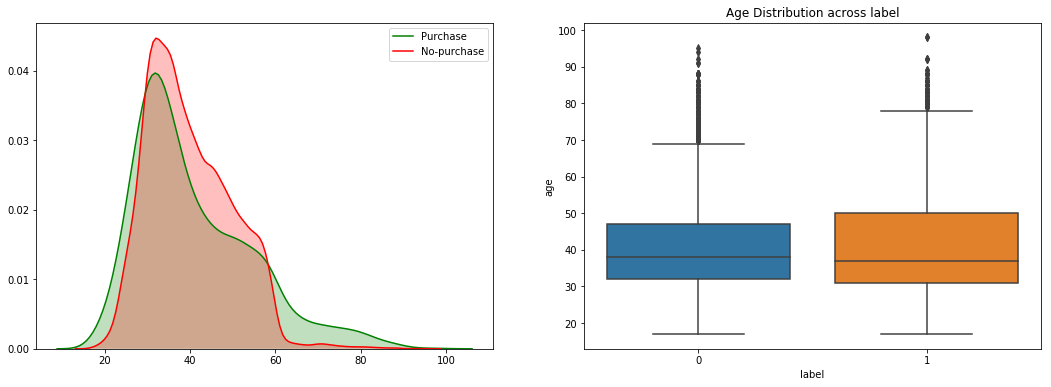

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

plt.title('Age Distribution across label')
sns.kdeplot(df[df.label == 1].age, shade=True, color="g", label='Purchase', ax=ax1)
sns.kdeplot(df[df.label == 0].age, shade=True, color="r", label='No-purchase', ax=ax1)

sns.boxplot(y='age', x='label', data=df, ax=ax2)

In [7]:
# importing two-sample t-test from scipy library
from scipy.stats import ttest_ind

t, p = ttest_ind(df[df.label == 1].age, df[df.label == 0].age, equal_var=False)
t, p

(4.779542781151716, 1.8047932698425662e-06)

###### Hence, there is a statistically significant difference in age between customer who purchased and did not make the purchase. (p<0.05).

* We can conduct similar tests across categorical variables (job, marital status & education), by using Chi-square Test.

###### Is there a significant difference within categories of job, marital status & education across label ?

In [8]:
# importing chi-square test from scipy library
from scipy.stats import chisquare, chi2_contingency

df_equal_label = pd.concat([df[df.label == 1], df[df.label == 0].sample(len(df[df.label == 1]))])

# generating job crosstab for equal dataset
crosstab_jobs = pd.crosstab(columns=df.job, index=df.label)
crosstab_jobs

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
label,,,,,,,,,,,,
0,9070,8616,1332,954,2596,1286,1272,3646,600,6013,870,293
1,1352,638,124,106,328,434,149,323,275,730,144,37


In [9]:
chi2, p, dof, expected = chi2_contingency(crosstab_jobs)

# p-value < 0.05
'%.8f' % (float(p))

'0.00000000'

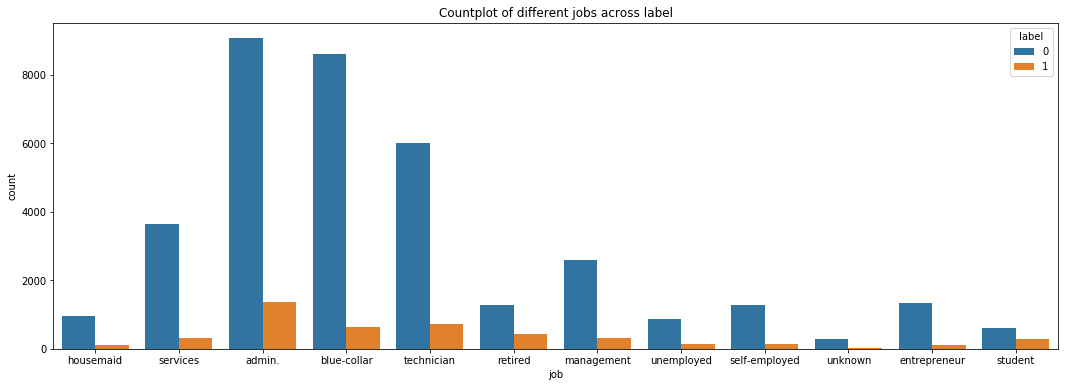

In [10]:
plt.figure(figsize=(18,6))
plt.title('Countplot of different jobs across label')
sns.countplot(x='job', hue='label', data=df)

###### Yes, the underlying categorical distributions are different for job column across the label of interest.

* Now, we repeat the same process for marital status & education.

In [11]:
# generating marital status crosstab for equal dataset
crosstab_marital = pd.crosstab(columns=df.marital, index=df.label, margins=True)
crosstab_marital

marital,divorced,married,single,unknown,All
label,,,,,
0,4136,22396,9948,68,36548
1,476,2532,1620,12,4640
All,4612,24928,11568,80,41188


In [12]:
chi2, p, dof, expected = chi2_contingency(crosstab_marital)

# p-value < 0.05
'%.8f' % (float(p))

'0.00000000'

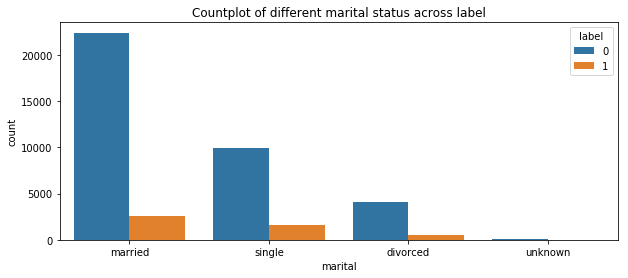

In [13]:
plt.figure(figsize=(10,4))
plt.title('Countplot of different marital status across label')
sns.countplot(x='marital', hue='label', data=df)

###### Yes, the underlying categorical distributions are different for marital status column across the label of interest.

In [14]:
# generating education crosstab for equal dataset
crosstab_edu = pd.crosstab(columns=df.education, index=df.label)
crosstab_edu

education,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown
label,,,,,,,,
0,3748,2104,5572,8484,14,4648,10498,1480
1,428,188,473,1031,4,595,1670,251


In [15]:
chi2, p, dof, expected = chi2_contingency(crosstab_edu)

# p-value < 0.05
'%.8f' % (float(p))

'0.00000000'

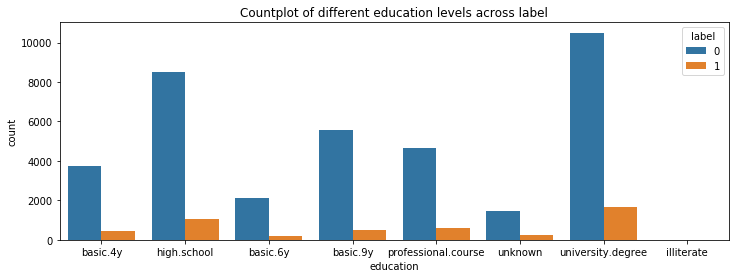

In [16]:
plt.figure(figsize=(12,4))
plt.title('Countplot of different education levels across label')
sns.countplot(x='education', hue='label', data=df)

###### Yes, the underlying categorical distributions are different for education column across the label of interest.

### Previous Behaviour Features:

We have features which show previous customer activity, let us take a look at them. (default, housing & loan).

In [17]:
behaviour_vars = ['default', 'housing', 'loan']

d = {}
for var in behaviour_vars:
    crosstab_temp = pd.crosstab(columns=df[var], index=df.label)
    chi2, p, dof, expected = chi2_contingency(crosstab_edu)

    d[var] = 'Significant' if p < 0.05 else 'Not-Significant'

d

{'default': 'Significant', 'housing': 'Significant', 'loan': 'Significant'}

* Hence, we observe that all behaviour features show significant differences across label on interest.

### 2.2). Scatterplots & Correlations <a class="anchor" id="2.2"></a>

* Now, let us take a look at linear relationships acorss different variables and also across the label of interest.

In [18]:
df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,label
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [19]:
df.groupby('label').mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
label,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


In [20]:
df.groupby('label').median()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
label,,,,,,,,,,
0,38.0,163.5,2.0,999.0,0.0,1.1,93.918,-41.8,4.857,5195.8
1,37.0,449.0,2.0,999.0,0.0,-1.8,93.200,-40.4,1.266,5099.1


* From the above tables, we observe that there is a difference in **duration of call**, showing longer calls tend to be much more effective than shorter call duration, with median of 163 & 449 (label 0 & 1).


* We also see that campaign, pdays, emp.var.rate, euribor3m & nr.employed are lower for label = 1 when compared to label = 0.

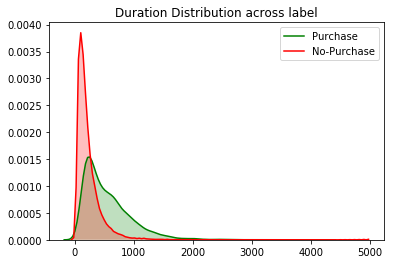

In [21]:
plt.title('Duration Distribution across label')
sns.kdeplot(df[df.label == 1].duration, shade=True, color="g", label='Purchase')
sns.kdeplot(df[df.label == 0].duration, shade=True, color="r", label='No-Purchase')

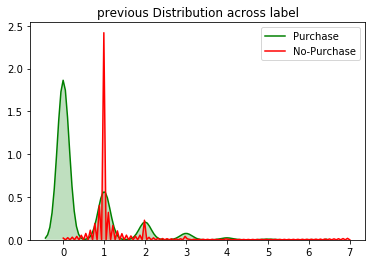

In [22]:
plt.title('previous Distribution across label')
sns.kdeplot(df[df.label == 1].previous, shade=True, color="g", label='Purchase')
sns.kdeplot(df[df.label == 0].previous, shade=True, color="r", label='No-Purchase')

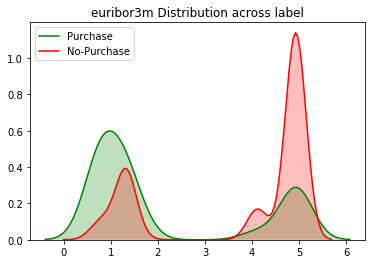

In [23]:
plt.title('euribor3m Distribution across label')
sns.kdeplot(df[df.label == 1].euribor3m, shade=True, color="g", label='Purchase')
sns.kdeplot(df[df.label == 0].euribor3m, shade=True, color="r", label='No-Purchase')

###### Conducting Two-sample hypothesis tests for above distributions does not make sense as they are non-normally distributed (either skewed or bi-model, etc).

In [24]:
df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,label
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


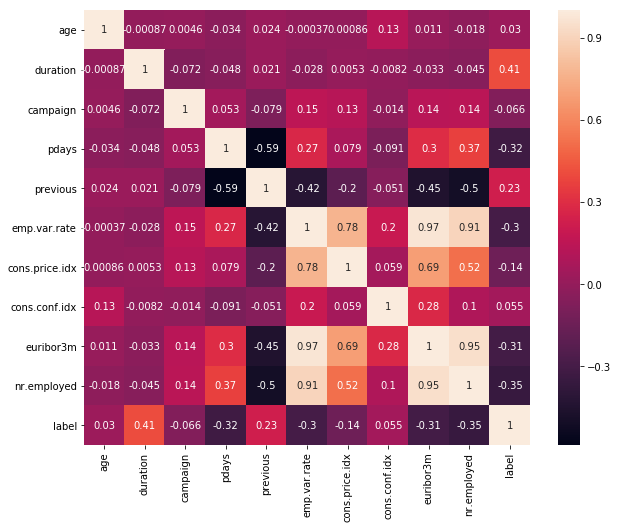

In [25]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True)